In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lmfit import minimize, Parameters
matplotlib.style.use('ggplot')

# % makes it in window instead of popout
%matplotlib inline

#pandas display options
from pandas import set_option
set_option("display.max_rows", 10)

In [2]:
#This is a function that takes a multiparametric data set with the name of the sample "extract_-dilution" as the rows 
#and biological parameters and returns a cleaned cp2 DataFrame indexed by Prefraction and a Dataframe to inform the
#dilution profiles.
def readBioData(file = ''):
    #open a tab delimitted file as a pandas dataframe
    cp1 = pd.read_table(file, sep = '\t')
    
    #This for loop makes two new columns 'Prefraction'and 'Dilution'
    for i in range(0, len(cp1['Features'])):
        name = cp1.get_value(col = 'Features', index = i)
        cp1.set_value(col='Prefraction',index = i, value = str(name.split('_')[0]))
        cp1.set_value(col='Dilution',index = i, value = int(name.split('-')[2]))
    
    #Index cp1 parameters by 'Prefraction' column
    cp1.index = cp1.Prefraction
    cp2 = cp1.iloc[0:,1:-2] #Clean CP Data
    
    #creates a dataframe with information about the diluted CP biological data
    dilutions = cp1['Dilution'][cp1['Dilution']>5]
    
    return dilutions, cp2

In [3]:
#This function takes a Markers Table from Unifi as a CSV File and returns a cleaned dataframe with prefractions 
#as its indices and mz_rt baskets as the columns
def markersTable(file = ''):
    marks = pd.read_csv(file)
    
    #For loop takes the labels from UNIFI and provides a clean 'Prefraction' Column
    for i in range(0, len(marks['PrimaryId'])):
        name = marks.get_value(col = 'PrimaryId', index = i)
        if '_' in str(name):
            marks.set_value(col='Prefraction',index = i, value = str(name).split('_')[1])
        else:
            marks.set_value(col='Prefraction',index=i, value='NaN')
    
    #Redefine indices as 'Prefractions'
    marks.index = marks.Prefraction
    
    return marks.iloc[4:,9:-1] #Slice of the data that only contains ints and floats

In [4]:
#This is a function that takes a cp dataframe with columns of cp parameters and rows indexed by Prefraction and returns
#an nxn matrix. Note only computes each value once xi,yi::yi,xi.
def nbyn(cp2):
    #import necessary libraries
    from scipy.stats import pearsonr
    
    #make nxn DataFrame
    nxn = pd.DataFrame(index = cp2.index, columns = cp2.index, dtype=float)
    
    #compute pearson correlations for lower half of nxn and reflect the other to save time
    for xi in nxn.index:        #loops over all rows
        for yi in nxn.loc[xi:,xi:].columns: #starts at diagonal and computes down a column and across the row
            if xi == yi:
                cos = 1
            else:
                #cos = coscore(cp2.loc[xi].values,cp2.loc[yi].values) 
                cos = pearsonr(cp2.loc[xi].values,cp2.loc[yi].values)[0]
            nxn.set_value(index = xi, col = yi, value = cos)
            nxn.set_value(index = yi, col = xi, value = cos)
    return nxn

#takes in two arrays and computes the cosine score between the two
def coscore(x, y):
	if not len(x) == len(y):
		print ("lengths not same")
		return None
	magx = sum([xi**2 for xi in x]) ** (1.0/2.0)
	magy = sum([yi**2 for yi in y]) ** (1.0/2.0)
	
	dot = 0.0
	for xi, yi in zip(x, y):
		dot += xi * yi
	dot /= float(magx * magy)
	return dot

In [5]:
def scale(dilutionTable, markersTable):
    scaled2 = markersTable.copy()
    for i in dilutionTable.index:
        for column in markersTable.columns:
            markersTable.set_value(col=column, index=i, value=5*scaled2.get_value(col=column, index=i)/dilutionTable[i])

In [6]:
diltab, cp = readBioData('3STDEV_Dilutions_ALL.txt')

In [6]:
marks = markersTable('Preliminary_MarkerTable.csv')

In [7]:
marks

,181.98852_0.041,158.00325_0.042,183.98785_0.042,180.99025_0.043,213.43665_0.043,167.01342_0.044,318.89495_0.045,280.09632_0.046,282.91003_0.046,449.81558_0.046,...,192.92237_4.480,179.01474_4.480,249.98378_4.480,230.95819_4.481,492.81335_4.481,288.91871_4.481,370.24553_4.483,167.01323_4.483,495.81331_4.484,194.11791_4.484
Prefraction,,,,,,,,,,,,,,,,,,,,,
Blank1,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,0.00
Blank2,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,0.00
Blank3,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,356.88,0,0,0,211.39
Blank4,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,216.59
Blank5,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,113.29,0,0.00,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Blank19,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,241.80
Blank18,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,258.00
RLPA-2032F,0,0,0,0,0,0,0,0,0,0,...,0.00,0,0,0.00,0,0.00,0,0,0,0.00


In [8]:
nxn = nbyn(cp)

In [9]:
unscaled = marks.copy()
scale(diltab, marks)

In [10]:
def blankRemove(marks):
    keeper = []
    blank = []
    for c in marks.columns:
        if "Blank" in marks[c][marks[c]>0].index:
            blank.append(c)
        else:
            keeper.append(c)
    return marks.loc[cp.index][keeper]

In [11]:
blanked = blankRemove(marks)
blanked

,181.98852_0.041,158.00325_0.042,183.98785_0.042,180.99025_0.043,213.43665_0.043,167.01342_0.044,318.89495_0.045,280.09632_0.046,282.91003_0.046,449.81558_0.046,...,394.79276_4.480,192.92237_4.480,179.01474_4.480,249.98378_4.480,230.95819_4.481,492.81335_4.481,288.91871_4.481,370.24553_4.483,167.01323_4.483,495.81331_4.484
Prefraction,,,,,,,,,,,,,,,,,,,,,
RLPA-1010A,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,0,0,0
RLPA-1010B,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,0,0,0
RLPA-1010C,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,198.44,0,0,0,0,0,0
RLPA-1010D,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,0,0,0
RLPA-1010E,0,0,0,0,0,1752.3,0,0,0,0,...,143.91,0.00,0,0.00,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RLPA-2032B,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,0,0,0
RLPA-2032C,0,0,0,0,0,0.0,0,0,0,0,...,0.00,0.00,0,0.00,0,0,0,0,0,0
RLPA-2032D,0,0,0,0,0,0.0,0,0,0,0,...,0.00,405.53,0,0.00,0,0,0,0,0,0


In [12]:
###Removes empty m/z, rt pairs that are present in blanks###
def emptyRemove(marks):
    keeper = []
    empty = []
    for c in marks.columns:
        if  len(marks[c][marks[c]>0].index) == 0:
            empty.append(c)
        else:
            keeper.append(c)
    return marks.loc[cp.index][keeper]

In [13]:
###Blanked and Empty###
clean = emptyRemove(blanked)
clean

,181.98852_0.041,158.00325_0.042,183.98785_0.042,180.99025_0.043,213.43665_0.043,167.01342_0.044,318.89495_0.045,280.09632_0.046,282.91003_0.046,449.81558_0.046,...,181.98901_4.479,279.09296_4.479,394.79276_4.480,192.92237_4.480,249.98378_4.480,492.81335_4.481,288.91871_4.481,370.24553_4.483,167.01323_4.483,495.81331_4.484
Prefraction,,,,,,,,,,,,,,,,,,,,,
RLPA-1010A,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,0.00,0,0,0,0,0
RLPA-1010B,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,0.00,0,0,0,0,0
RLPA-1010C,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,198.44,0,0,0,0,0
RLPA-1010D,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,0.00,0,0,0,0,0
RLPA-1010E,0,0,0,0,0,1752.3,0,0,0,0,...,0,0,143.91,0.00,0.00,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RLPA-2032B,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,0.00,0,0,0,0,0
RLPA-2032C,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,0.00,0.00,0,0,0,0,0
RLPA-2032D,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0.00,405.53,0.00,0,0,0,0,0


In [14]:
blankedUnscaled = blankRemove(unscaled)
cleanUnscaled = emptyRemove(blankedUnscaled)

In [15]:
#This is going to be a Feature class that describes the distribrution 
#and intensities of each adduct throughout the dataset
class Feature():
    def __init__(self, mz_rt, marks, cp, nxn, aIDn):
        self.label = 'aID' + str(aIDn)
        self.subtable = marks[mz_rt][marks[mz_rt]>0]
        self.runs = marks[mz_rt][marks[mz_rt]>0].index
        self.mz = mz_rt.split('_')[0]                         #Value stored as string to preserve significant figures
        self.rt = mz_rt.split('_')[1]                         #Value stored as string to preserve significant figures
        self.subNXN = nxn.loc[self.runs,self.runs]
        self.cScore = Feature.clusterScore(self.runs, nxn)    #Note different calculation from PNAS Paper
        self.syntheticFingerprint = cp.loc[self.runs].mean()
        #self.aScore = Feature.activityScore(self.syntheticFingerprint)
        
        ###Neat Trick
        self.aScore = (sum(cp.loc[self.runs].mean()**2))**(1/2)
        #self.synthWeighted 
    
    #function taxes one DataFrame and one array: one NXN of pearson correlations from all runs 
    #and an array of all the runs
    def clusterScore(runs, nxn):
        if len(runs)==0:
            return 0
        else:
            subNXN = nxn.loc[runs,runs]**3
            return float(subNXN.sum().sum()-len(runs))/(2*len(runs))
    
    #This function takes the cp fingerprint DataFrame and a subtable of runs and peak heights
    def syntheticFingerprint(subtable, cp):
        synth = cp.loc[runs]
    
    #This is a function that takes the synthetic fingerprint and computes the magnitude in order to 
    #estimate the overall activity
    def activityScore(syn):
        aScore = 0
        for i in syn:
            aScore += i**2
        return aScore**(1/2)

In [16]:
def analyze(marks, cp, nxn):
    adducts = []
    aIDn = 0
    for c in marks.columns:
        i = Feature(c, marks, cp, nxn, aIDn)
        i.label = pd.DataFrame({'mz': i.mz,
                               'rt': i.rt ,
                               'Cluster Score': i.cScore,
                               'Activity Score': i.aScore, 
                                'Runs': [i.runs],
                                'Frequency': len(i.runs)
                               },index = [i.label])
        adducts.append(i.label)
        aIDn +=1
    adductsTable = pd.concat(adducts)
    return adductsTable

In [22]:
###Make the DataFrame with all the adducts with aID and attributes as columns
rtdemo = analyze(blankedUnscaled, cp, nxn)
rtdemo

,Activity Score,Cluster Score,Frequency,Runs,mz,rt
aID0,2.360881,0.000000,1,"Index(['RLPA-2002F'], dtype='object', name='Pr...",181.98852,0.041
aID1,0.843552,0.180682,2,"Index(['RLPA-2011A', 'RLPA-2027A'], dtype='obj...",158.00325,0.042
aID2,0.907865,0.056910,4,"Index(['RLPA-1011A', 'RLPA-2004E', 'RLPA-2009E...",183.98785,0.042
aID3,0.767491,0.051527,3,"Index(['RLPA-2011F', 'RLPA-2019D', 'RLPA-2023B...",180.99025,0.043
aID4,1.066262,0.000000,1,"Index(['RLPA-2009D'], dtype='object', name='Pr...",213.43665,0.043
...,...,...,...,...,...,...
aID49501,1.295856,0.000000,1,"Index(['RLPA-2031F'], dtype='object', name='Pr...",492.81335,4.481
aID49502,1.499700,0.212400,10,"Index(['RLPA-1011E', 'RLPA-1012D', 'RLPA-1020D...",288.91871,4.481
aID49503,2.014174,0.000030,2,"Index(['RLPA-2007C', 'RLPA-2011C'], dtype='obj...",370.24553,4.483
aID49504,0.772899,0.319701,11,"Index(['RLPA-1020F', 'RLPA-2002A', 'RLPA-2005A...",167.01323,4.483


In [18]:
###Remove ions in more than 6 prefractions(AGGRESSIVE)
underRep = rtdemo[rtdemo['Frequency'] < 6]

In [19]:
#Filter activity score < 3
active = underRep[underRep['Activity Score'] > 3]
#Filter cluster score < 0.4
activeConsistent = active[active['Cluster Score'] > 0.4]
#Filter out singletons, but it turns out that doesn't do anything
done = activeConsistent[activeConsistent['Frequency'] > 1]

In [20]:
from collections import Counter

In [21]:
#lambda function to convert rt values into integer
normalizeRT = lambda t: t*60//1

#Counter function makes a dictionary like object with keys at integer rt with value as number of ions with that rt
d = Counter(normalizeRT(float(t)) for t in rtdemo['rt'].values)
e = Counter(normalizeRT(float(t)) for t in underRep['rt'].values)
f = Counter(normalizeRT(float(t)) for t in activeConsistent['rt'].values)
g = Counter(normalizeRT(float(t)) for t in activeConsistent['rt'].values)

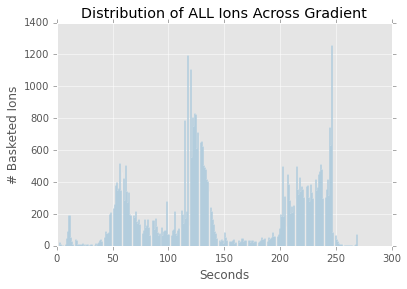

In [211]:
###Plot all of the things
plt.bar(d.keys(),height = d.values())
plt.xlabel("Seconds")
plt.ylabel("# Basketed Ions")
plt.title("Distribution of ALL Ions Across Gradient")
plt.show()

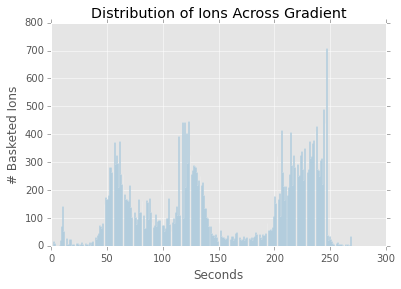

In [181]:
###Filter out ions in greater than 6 prefractions###
plt.bar(e.keys(),height = e.values())
plt.xlabel("Seconds")
plt.ylabel("# Basketed Ions")
plt.title("Ions in < 6 Prefractions Across Gradient")
plt.show()

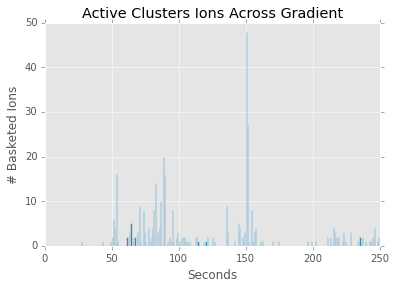

In [23]:
###Activity Score and Cluster Score Filters###
plt.bar(f.keys(),height = f.values())
plt.xlabel("Seconds")
plt.ylabel("# Basketed Ions")
plt.title("Active Clusters Ions Across Gradient")
plt.show()

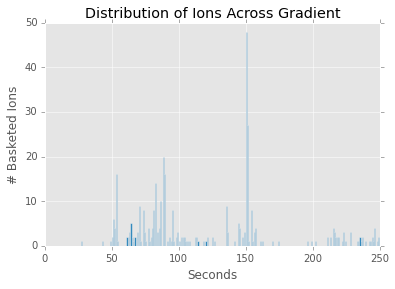

In [183]:
###No Singletons###
plt.bar(g.keys(),height = g.values())
plt.xlabel("Seconds")
plt.ylabel("# Basketed Ions")
plt.title("Distribution of Ions Across Gradient")
plt.show()

In [184]:
###What Happens to Staurosporine M + Na###
staurosporineMplusNa = done[done['mz'] == '489.18891']
staurosporineMplusNa

,Activity Score,Cluster Score,Frequency,Runs,mz,rt
aID10852,4.268765,0.54688,5,"Index(['RLPA-1011D', 'RLPA-1011E', 'RLPA-1011F...",489.18891,1.435


In [202]:
###Gotta Convert all the rts into floats###
num = lambda n: float(n)
RT = [num(rt) for rt in done['rt'].values]
done['RT'] = RT
RT

[0.455,
 0.717,
 0.832,
 0.836,
 0.839,
 0.852,
 0.856,
 0.862,
 0.863,
 0.864,
 0.865,
 0.868,
 0.868,
 0.869,
 0.871,
 0.888,
 0.889,
 0.89,
 0.892,
 0.892,
 0.892,
 0.892,
 0.893,
 0.893,
 0.893,
 0.893,
 0.893,
 0.893,
 0.893,
 0.893,
 0.894,
 0.901,
 1.025,
 1.033,
 1.04,
 1.044,
 1.059,
 1.059,
 1.06,
 1.07,
 1.071,
 1.073,
 1.083,
 1.083,
 1.093,
 1.098,
 1.101,
 1.124,
 1.133,
 1.16,
 1.16,
 1.16,
 1.17,
 1.172,
 1.176,
 1.176,
 1.176,
 1.176,
 1.177,
 1.177,
 1.178,
 1.198,
 1.219,
 1.223,
 1.223,
 1.224,
 1.226,
 1.227,
 1.228,
 1.231,
 1.241,
 1.248,
 1.248,
 1.266,
 1.288,
 1.289,
 1.293,
 1.295,
 1.316,
 1.323,
 1.328,
 1.345,
 1.345,
 1.346,
 1.347,
 1.362,
 1.362,
 1.362,
 1.363,
 1.363,
 1.363,
 1.366,
 1.366,
 1.369,
 1.37,
 1.374,
 1.375,
 1.375,
 1.375,
 1.375,
 1.375,
 1.376,
 1.376,
 1.377,
 1.377,
 1.378,
 1.379,
 1.402,
 1.402,
 1.405,
 1.423,
 1.423,
 1.43,
 1.431,
 1.434,
 1.435,
 1.435,
 1.436,
 1.437,
 1.438,
 1.438,
 1.439,
 1.439,
 1.443,
 1.472,
 1.472,
 1

In [210]:
###Looking at the wierd spike at 150 and it is all Actinomycins###
rna = done[done['RT'] > (145/60)]
rnb = rna[rna['RT'] < (155/60)]
rnb

,Activity Score,Cluster Score,Frequency,Runs,mz,rt,RT
aID29151,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",1263.59656,2.417,2.417
aID29164,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",643.29386,2.422,2.422
aID29168,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",1241.61489,2.422,2.422
aID29184,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",643.79771,2.429,2.429
aID29251,5.747354,0.413260,2,"Index(['RLPA-2008E', 'RLPA-2008F'], dtype='obj...",1251.59772,2.460,2.460
...,...,...,...,...,...,...,...
aID29555,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",1291.62525,2.581,2.581
aID29556,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",1305.60806,2.581,2.581
aID29558,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",635.82736,2.582,2.582
aID29559,5.592901,0.734052,3,"Index(['RLPA-2008D', 'RLPA-2008E', 'RLPA-2008F...",635.32576,2.582,2.582


In [176]:
rtdemo['Activity Score'].mean()

2.122037166908058

In [169]:
for c in marks.columns:
    if '489.1' in c:
        print(c)

489.15413_1.236
489.18891_1.435
489.10431_2.003
489.18939_3.475


In [29]:
stauroScaled = Feature('489.18891_1.435', clean, cp, nxn, 1)

In [30]:
stauroScaled.aScore

4.2687645894587734

In [26]:
stauroUnScaled = Feature('489.18891_1.435', cleanUnscaled, cp, nxn, 1)

In [59]:
stauroUnScaled.aScore

4.2687645894587734

In [39]:
stauroScaled.syntheticFingerprint

MICRO_AND_BINUCLEATED_CELLS_MICRONUCLEI_EDU              0.000000
MICRO_AND_PROBEABPOSITIVE_CELLS_MICRONUCLEI_EDU          0.002170
MICRO_AND_PROBEBPOSITIVE_CELLS_MICRONUCLEI_EDU           0.001298
MICRO_AND_PROBEAPOSITIVE_CELLS_MICRONUCLEI_EDU          -0.140589
INTERPHASE_CELLS_MICRONUCLEI_EDU                         0.040085
                                                           ...   
CELL_NUCLEAR_AVERAGE_INTENSITY_TRANSFLUOR_EDU            0.057801
DAPI_AVERAGE_INTENSITY_MULTIWAVESCORING_EDU              0.058152
NUCLEAR_AVERAGE_INTENSITY_TRANSFLUOR_EDU                 0.177603
ALL_NUCLEI_MEAN_AVERAGE_ITENSITY_MULTIWAVESCORING_EDU    0.254302
AVERAGE_INTENSITY_IMA_SUMMARY_EDU                        0.237459
dtype: float64

In [29]:
stauroUnScaled.sy

Prefraction
RLPA-1011D    8298.18
RLPA-1011E    1772.53
RLPA-1011F     271.21
RLPA-2005D    1600.30
RLPA-2005E    2612.06
Name: 489.18891_1.435, dtype: float64

In [34]:
for ind in stauroUnScaled.subtable.index:
    print(sum(cp.loc[ind]**2))
    

35.0157372957
35.9580367048
29.1171879954
6.27936231802
38.372156559


In [91]:
data = []
for ind in stauroScaled.subtable.index:
    data.append(sum(cp.loc[ind]**2))

In [37]:
def semi_log(params, x, data):
    lam = params['lambda'].value
    A = params['constant'].value
    gamma = params['gamma']
    offset = params['offset']
    
    model = lam*A**(x*gamma) + offset
    
    return data - model

In [90]:
data = []

In [88]:
xS = stauroScaled.subtable.values
xU = stauroUnScaled.subtable.values

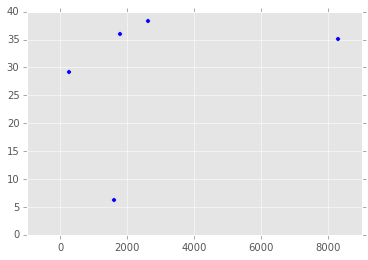

In [93]:
#plt.scatter(xS, data,)
plt.scatter(xU, data)

In [68]:
for c in marks.columns:
    if '1123.4' in c:
        print(c)

1123.40602_2.098
1123.40229_2.274


In [73]:
echino = Feature('1123.40602_2.098',cleanUnscaled, cp, nxn, 1)

In [74]:
echino.runs

Index(['RLPA-2004A', 'RLPA-2005D', 'RLPA-2005E', 'RLPA-2005F'], dtype='object', name='Prefraction')

In [75]:
echino.aScore

3.1348938168805187

In [76]:
data = []
for ind in echino.subtable.index:
    data.append(sum(cp.loc[ind]**2))

In [78]:
xE = echino.subtable.values

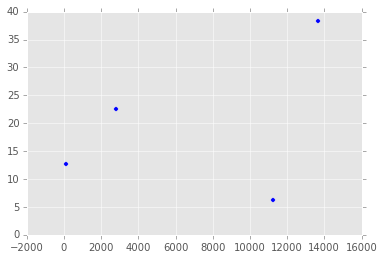

In [79]:
plt.scatter(xE,data)

In [80]:
echino.subtable

Prefraction
RLPA-2004A      111.08
RLPA-2005D    11230.28
RLPA-2005E    13638.54
RLPA-2005F     2776.60
Name: 1123.40602_2.098, dtype: float64

In [82]:
echinoScaled = Feature('1123.40602_2.098',clean, cp, nxn, 1)

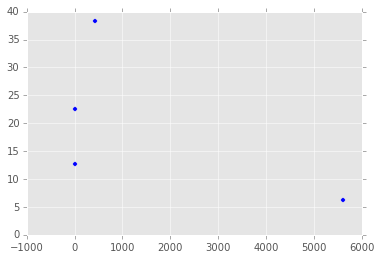

In [83]:
eXS = echinoScaled.subtable.values
plt.scatter(eXS, data)

In [84]:
echinoScaled.subtable

Prefraction
RLPA-2004A       3.471250
RLPA-2005D    5615.140000
RLPA-2005E     426.204375
RLPA-2005F      17.353750
Name: 1123.40602_2.098, dtype: float64

In [17]:
g = analyze(clean, cp, nxn)

In [27]:
len(g.loc['aID1']['Runs'].values)

2

In [32]:
g

,Activity Score,Cluster Score,Runs,mz,rt
aID0,2.360881,0.000000,"Index(['RLPA-2002F'], dtype='object', name='Pr...",181.98852,0.041
aID1,0.843552,0.180682,"Index(['RLPA-2011A', 'RLPA-2027A'], dtype='obj...",158.00325,0.042
aID2,0.907865,0.056910,"Index(['RLPA-1011A', 'RLPA-2004E', 'RLPA-2009E...",183.98785,0.042
aID3,0.767491,0.051527,"Index(['RLPA-2011F', 'RLPA-2019D', 'RLPA-2023B...",180.99025,0.043
aID4,1.066262,0.000000,"Index(['RLPA-2009D'], dtype='object', name='Pr...",213.43665,0.043
...,...,...,...,...,...
aID42296,1.295856,0.000000,"Index(['RLPA-2031F'], dtype='object', name='Pr...",492.81335,4.481
aID42297,1.499700,0.212400,"Index(['RLPA-1011E', 'RLPA-1012D', 'RLPA-1020D...",288.91871,4.481
aID42298,2.014174,0.000030,"Index(['RLPA-2007C', 'RLPA-2011C'], dtype='obj...",370.24553,4.483
aID42299,0.772899,0.319701,"Index(['RLPA-1020F', 'RLPA-2002A', 'RLPA-2005A...",167.01323,4.483


In [34]:
g

,Activity Score,Cluster Score,Runs,mz,rt
aID0,2.360881,0.000000,"Index(['RLPA-2002F'], dtype='object', name='Pr...",181.98852,0.041
aID1,0.843552,0.180682,"Index(['RLPA-2011A', 'RLPA-2027A'], dtype='obj...",158.00325,0.042
aID2,0.907865,0.056910,"Index(['RLPA-1011A', 'RLPA-2004E', 'RLPA-2009E...",183.98785,0.042
aID3,0.767491,0.051527,"Index(['RLPA-2011F', 'RLPA-2019D', 'RLPA-2023B...",180.99025,0.043
aID4,1.066262,0.000000,"Index(['RLPA-2009D'], dtype='object', name='Pr...",213.43665,0.043
...,...,...,...,...,...
aID42296,1.295856,0.000000,"Index(['RLPA-2031F'], dtype='object', name='Pr...",492.81335,4.481
aID42297,1.499700,0.212400,"Index(['RLPA-1011E', 'RLPA-1012D', 'RLPA-1020D...",288.91871,4.481
aID42298,2.014174,0.000030,"Index(['RLPA-2007C', 'RLPA-2011C'], dtype='obj...",370.24553,4.483
aID42299,0.772899,0.319701,"Index(['RLPA-1020F', 'RLPA-2002A', 'RLPA-2005A...",167.01323,4.483


In [33]:
active = g.iloc[0:][g['Activity Score']>3.3]

In [35]:
active_clustered = active.iloc[0:][active['Cluster Score'] > 0.10]

In [115]:
active_clustered['Activity Score'].max()

6.0768635221414

In [36]:
active_clustered

,Activity Score,Cluster Score,Runs,mz,rt
aID410,3.383279,0.286310,"Index(['RLPA-1020D', 'RLPA-2001D', 'RLPA-2004D...",238.96339,0.186
aID760,3.838029,0.201924,"Index(['RLPA-1014D', 'RLPA-2004D'], dtype='obj...",264.96831,0.382
aID806,3.351446,0.796787,"Index(['RLPA-1021B', 'RLPA-2004B', 'RLPA-2017B...",647.23282,0.455
aID940,3.915693,0.399210,"Index(['RLPA-1010C', 'RLPA-1021B', 'RLPA-2004B...",317.21727,0.642
aID1027,4.016918,0.105195,"Index(['RLPA-1020D', 'RLPA-2028E'], dtype='obj...",483.79727,0.691
...,...,...,...,...,...
aID42046,5.729919,0.409831,"Index(['RLPA-1010E', 'RLPA-2011E'], dtype='obj...",534.74252,4.164
aID42058,3.467233,0.177548,"Index(['RLPA-1010F', 'RLPA-1014D'], dtype='obj...",315.88256,4.167
aID42060,3.428926,0.212834,"Index(['RLPA-2002D', 'RLPA-2004A'], dtype='obj...",538.74941,4.168
aID42157,3.630137,0.144185,"Index(['RLPA-1014D', 'RLPA-1021D'], dtype='obj...",318.89432,4.265


In [25]:
plt.figure();

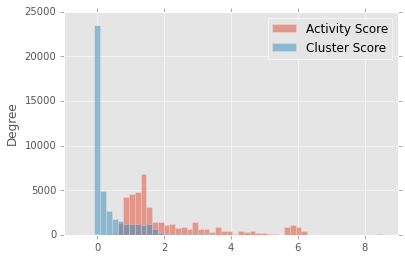

In [37]:
g.plot(kind='hist', alpha = 0.5, bins = 50)

In [40]:
from pandas.tools.plotting import bootstrap_plot

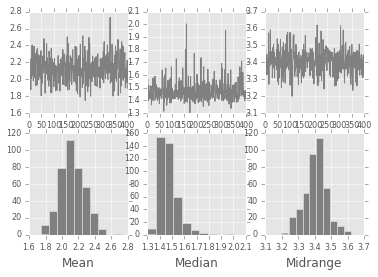

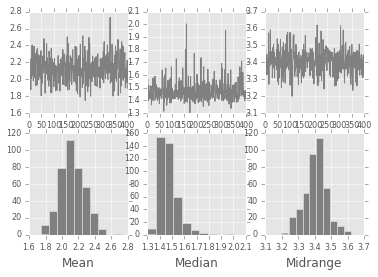

In [43]:
bootstrap_plot(g['Activity Score'], size=100, samples=400, color='grey')

TypeError: radviz() missing 1 required positional argument: 'class_column'

In [36]:
a,b,c = Feature('181.98852_0.041', clean, cp, nxn),Feature('449.81558_0.046', clean, cp, nxn),Feature('394.79276_4.480',clean, cp, nxn)

In [38]:
a.runs

Index(['RLPA-2002F'], dtype='object', name='Prefraction')

In [46]:
cdd = pd.DataFrame({'mz': b.mz,
                               'rt': c.rt ,
                               'Cluster Score': c.cScore,
                               'Activity Score': c.aScore,
                               }, index = [0])

In [47]:
frames = [add,bdd,cdd]

In [50]:
comb = pd.concat(frames, ignore_index=True)

In [51]:
comb

,Activity Score,Cluster Score,mz,rt
0,2.360881,0,181.98852,0.041
1,5.723054,0,449.81558,0.046
2,5.945873,0,449.81558,4.480
